# dataset
Generate dataset for the recommendation system plroblem

In [106]:
!rm -rf feature_repo/data/*

In [107]:
!python3 dataset_gen.py

Users sample:
   user_id  age gender signup_date          preferences
0        1   56      F  2023-09-28  Home,Books,Clothing
1        2   36      M  2023-03-29          Electronics
2        3   19      F  2023-10-21       Clothing,Books
3        4   39      M  2023-12-11          Electronics
4        5   45  Other  2023-09-28    Electronics,Books

Items sample:
   item_id  category  subcategory  ...  new_arrival  on_sale        arrival_date
0        1    Sports  Team Sports  ...        False    False 2023-03-13 04:48:00
1        2      Home      Kitchen  ...        False     True 2023-08-31 09:14:00
2        3     Books      Science  ...        False    False 2023-01-02 12:40:00
3        4  Clothing  Accessories  ...        False    False 2023-05-08 06:41:00
4        5    Sports  Team Sports  ...        False    False 2023-05-27 08:28:00

[5 rows x 10 columns]

Interactions sample:
   interaction_id  user_id  item_id  ... interaction_type rating  quantity
0               1      382   

# Setup Feature Store

We run the `feast apply` command to register the data

In [108]:
# ! feast init feature_repo

In [109]:
!cd feature_repo/ ; feast apply 

/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/feast/feature_view.py:48: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity '__dummy'.
  DUMMY_ENTITY = Entity(
/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "vector_enabled" in "SqliteOnlineStoreConfig" shadows an attribute in parent "VectorStoreConfig"
  warnings.warn(
/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "vector_len" in "SqliteOnlineStoreConfig" shadows an attribute in parent "VectorStoreConfig"
  warnings.warn(
No project found in the repository. Using project name feast_edb_rec_sys defined in feature_store.yaml
Applying changes for project feast_edb_rec_sys
Created project feast_edb_rec_sys
Created entity user
Created entity item
Created feature view user_featu

In [110]:
from feast import FeatureStore
from datetime import datetime, timedelta

store = FeatureStore(repo_path="feature_repo/")

# Generating datasets using Feast

In [111]:
from feast import FeatureService
import pandas as pd
from itertools import product
# load feature services
item_service = store.get_feature_service("item_service")
user_service = store.get_feature_service("user_service")
interaction_service = store.get_feature_service("interaction_service")

user_ids = list(range(1, 1_000))
item_ids = list(range(1, 5_000))

# select which entities to use
item_entity_df = pd.DataFrame.from_dict(
    {
        'item_id': item_ids,
        'event_timestamp': [datetime(2025, 1, 1)] * len(item_ids) 
    }
)
user_entity_df = pd.DataFrame.from_dict(
    {
        'user_id': user_ids,
        'event_timestamp': [datetime(2025, 1, 1)] * len(user_ids) 
    }
)
item_user_interactions_df = pd.read_parquet('./feature_repo/data/interactions_item_user_ids.parquet')
item_user_interactions_df['event_timestamp'] = datetime(2025, 1, 1)

# retrive datasets for training
item_df = store.get_historical_features(entity_df=item_entity_df, features=item_service).to_df()
user_df = store.get_historical_features(entity_df=user_entity_df, features=user_service).to_df()
interaction_df = store.get_historical_features(entity_df=item_user_interactions_df, features=interaction_service).to_df()

# Training

In [112]:
# from models import ItemEncoder, UserEncoder, TwoTowerModel, train_two_tower
# dim = 512

# item_encoder = ItemEncoder(dim)
# user_encoder = UserEncoder(dim)
# two_tower_model = TwoTowerModel(item_encoder=item_encoder, user_encoder=user_encoder)
# train_two_tower(two_tower_model, item_df, user_df, interaction_df)

# Batch scoring
Encode the items and users vector representation

In [113]:
# embeded_items = item_encoder(item_df)
# embeded_users = user_encoder(user_df)
# item_df['embedding'] = embeded_items
# user_df['embedding'] = embeded_users

# # Push the new embedding to the offline and online store
# store.push('user_embed_push_source', item_df)
# store.push('item_embed_push_source', user_df)
# # store.push('user_embed_push_source', item_df[['item_id', 'embedding']])
# # store.push('item_embed_push_source', user_df[['user_id', 'embedding']])

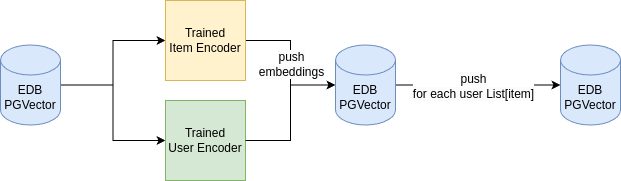

Problem that arises
* after pushing the 

In [114]:
from feast.data_source import PushMode
import numpy as np
k = 10

# Create embedding for items and users
# embeded_items = item_encoder(item_df)
# embeded_users = user_encoder(user_df)
item_embed_df = item_df[['item_id']].copy()
user_embed_df = user_df[['user_id']].copy()

item_embed_df['embedding'] = np.random.randn(len(item_embed_df), 64).tolist()
user_embed_df['embedding'] = np.random.randn(len(user_embed_df), 64).tolist()
item_embed_df['event_timestamp'] = datetime.now()
user_embed_df['event_timestamp'] = datetime.now()

# Push the new embedding to the offline and online store
store.push('item_embed_push_source', item_embed_df, to=PushMode.ONLINE_AND_OFFLINE)
store.push('user_embed_push_source', user_embed_df, to=PushMode.ONLINE_AND_OFFLINE)

# Materialize
Materialization generates the latest values for each entity key in the online store and creates a time-based index to enhance retrieval speed.
The `materialize-incremental `command materializes the offline store initially and, on subsequent runs, ingests only new data and updates the store.

In [115]:
# store.materialize_incremental(datetime.now(), feature_views=['item_embedding'])
store.materialize_incremental(datetime.now() - timedelta(days=365 * 5), feature_views=['item_embedding'])

Materializing 1 feature views to 2020-03-07 17:43:48+02:00 into the sqlite online store.

item_embedding from 2020-03-07 17:43:48+02:00 to 2020-03-07 17:43:48+02:00:


/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/feast/entity.py:173: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity 'item'.
  entity = cls(
0it [00:00, ?it/s]


In [116]:
store.get_online_features(store.get_feature_service('item_embedding'), [{'item_id': i} for i in range(1, 5000)]).to_df()

/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/feast/entity.py:173: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity 'user'.
  entity = cls(
/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/feast/entity.py:173: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity 'item'.
  entity = cls(
/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/feast/entity.py:173: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity '__dummy'.
  entity = cls(


,item_id,embedding
0,1,"[-1.3484702110290527, -0.6716884970664978, -1...."
1,2,"[-1.3126925230026245, 0.5846939086914062, -1.5..."
2,3,"[1.573253870010376, 0.47619614005088806, -0.70..."
3,4,"[-0.8317111730575562, 1.628764033317566, -0.42..."
4,5,"[-0.7451332807540894, -0.9287019371986389, 0.9..."
...,...,...
4994,4995,"[-0.49576976895332336, 0.0219541247934103, 0.1..."
4995,4996,"[0.30296850204467773, -0.25153112411499023, 0...."
4996,4997,"[-0.229095920920372, -1.2500381469726562, -0.6..."
4997,4998,"[-0.10956749320030212, -0.11476978659629822, 0..."


In [117]:
# Calculate user recommendations for each user
item_embedding_view = 'item_embedding'
user_embedding_view = 'user_embedding'

item_recommendation = []
for user_embed in user_embed_df['embedding']:
    item_recommendation.append(
        store.retrieve_online_documents_v2(
            query=user_embed,
            top_k=k,
            features=[f'{item_embedding_view}:embedding',
                      f'{item_embedding_view}:item_id']
        )
    )

# Pushing the calculated items to the online store
user_items_df = user_embed_df[['user_id']].copy()
user_items_df['event_timestamp'] = datetime.now()
user_items_df['top_k_item_ids'] = item_recommendation

store.push('user_items_push_source', user_items_df, to=PushMode.OFFLINE)

OperationalError: UNIQUE constraint failed on vec_table primary key

In [118]:
item_recommendation[0].to_df()

,embedding,item_id,distance
0,"[0.7750775218009949, 0.977125883102417, -0.518...",None,8.603783
1,"[0.6209911704063416, 0.6175487637519836, -0.39...",None,8.549447
2,"[1.3543285131454468, 0.7130129933357239, 0.147...",None,8.451757
3,"[-1.288988471031189, 2.011756181716919, -0.736...",None,8.241433
4,"[1.1395989656448364, 0.37299424409866333, 0.46...",None,8.501476
5,"[-0.40435928106307983, 0.7274473309516907, 0.9...",None,8.537401
6,"[-0.09480001032352448, 1.4703071117401123, 0.0...",None,8.392163
7,"[0.005286457948386669, -0.5898598432540894, 1....",None,8.721828
8,"[0.1009630635380745, 1.1671462059020996, 1.039...",None,8.557496
9,"[-0.17637330293655396, 0.005112900398671627, -...",None,8.593702


# Inferencing

## Existing User Case

## New User Case
